In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
from pandas_profiling import ProfileReport 

warnings.filterwarnings('ignore')

# Zbiór danych opisuje sytuację pożarową portugalskich lasów.
## Celem zadania jest przewidzenie (na podstawie danych meteorologicznych, geograficznych itp.) możliwego pożaru mierzonego w jednostce spalonych hektarów lasu. Jest to więc zadanie regresji.

## Aby rozwiązać to zadanie, najpierw musimy lepiej poznać zbiór danych na podstawie którego chcemy przeprowadzić uczenie maszynowe.

In [2]:
# wczytanie zbioru danych
fires_df = pd.read_csv("forest_fires_dataset.csv")

# aby poznać ogólny wygląd ramki danych stosujemy funckję head()
fires_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,0.0


In [3]:
# używamy funkcji info(), aby sprawdzić w jakim formacie są zapisane poszczególne dane oraz ile z nich jest wartością Null
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    float64
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


Jak widać, żaden z 517 rekordów nie zawiera wartości pustych.

Najpierw zamieńmy skrótowe nazwy miesięcy na liczby, pomoże to w dalszej części wizualizacji.

In [4]:
converter = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5,
            'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
fires_df['month'] = fires_df['month'].apply(lambda x: converter[x])

To samo zróbmy z dniami tygodnia.

In [5]:
converter = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5,
            'sat': 6, 'sun': 7}
fires_df['day'] = fires_df['day'].apply(lambda x: converter[x])
fires_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51.0,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99.0,1.8,0.0,0.0


Sprawdźmy rozkłady wszystkich zmiennych zawartych w ramce danych.

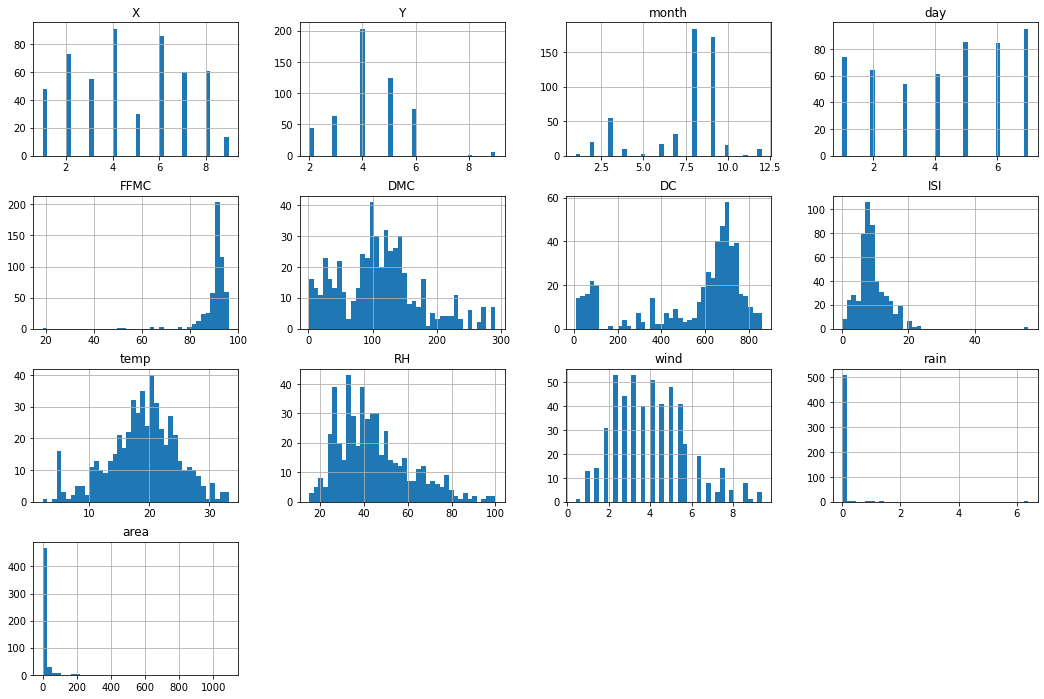

In [6]:
fires_df.hist(bins = 40, figsize=(18, 12));

Zauważmy, że wykres rozkładu zmiennej 'area' jest bardzo skupiony w zerze, przez co reszta wartości jest niewidoczna. Sprawdźmy boxplot tej zmiennej.

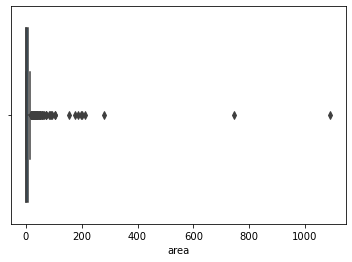

In [7]:
box_plot = sns.boxplot(fires_df['area'])

Boxplot ten jest absolutnie nieczytelny za sprawą outlierów. Na pierwszy rzut oka widać dwie bardzo duże wartości (ok. 730 i ok. 1100), których usunięcie z wykresu zdecydowanie poprawi jego przejrzystość.

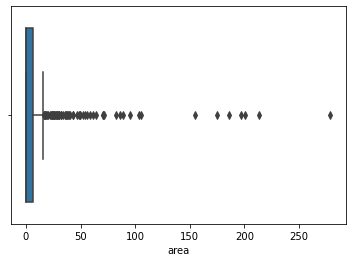

In [8]:
box_plot = sns.boxplot(fires_df['area'][fires_df.area < 400])

Tym razem widzimy kolejne 9 ekstremalnych outlierów, je również usuniemy.

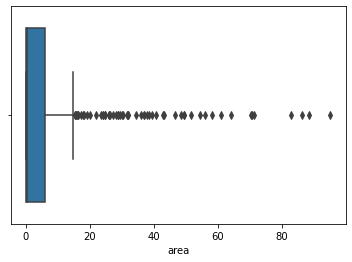

In [9]:
box_plot = sns.boxplot(fires_df['area'][fires_df.area < 100])

W ten sposób odrzucając tylko 11 największych pod względem 'area' rekordów  (ze wszystkich 517), znacząco poprawiliśmy przejrzystośc wykresów. Te rekordy będziemy odrzucać również w dalszej części tego raportu. 

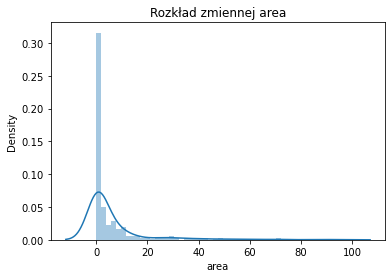

In [10]:
area_dist = sns.distplot(fires_df['area'][fires_df.area < 100])
area_dist.set_title('Rozkład zmiennej area')
plt.show()

Przez bardzo mocną dominację wartości zerowych wykres jest nieczytelny. Sprawdźmy więc jak wygląda rozkład zmiennej area pod warunkiem, że pożar wystąpił (czyli area > 0). Do tego area została ograniczona do 100, ponieważ rekordy o spalonej powierzchni powyżej 100 Ha stanowią niewielki ułamek wszystkich pożarów, a zaburzają przejrzystość wykresu.

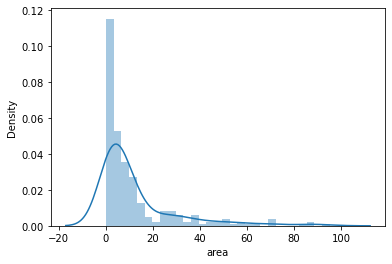

In [11]:
area_dist = sns.distplot(fires_df[fires_df.area > 0][fires_df.area < 100]['area'])

Następnie sprawdzamy zależności między zmienną Target a pozostałymi zmiennymi. Zmienne kategoryczne (month i day) na razie pomińmy.

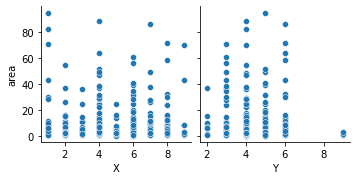

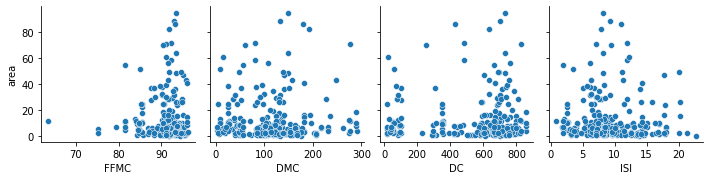

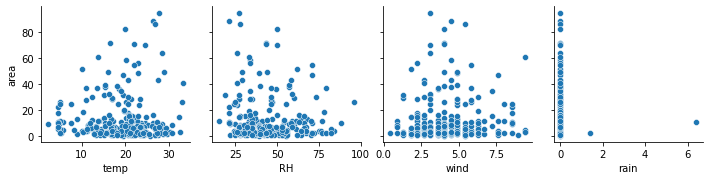

In [12]:
sns.pairplot(fires_df[fires_df.area < 100][fires_df.area > 0], y_vars="area", x_vars=fires_df.columns.values[:2])
sns.pairplot(fires_df[fires_df.area < 100][fires_df.area > 0], y_vars="area", x_vars=fires_df.columns.values[4:8])
sns.pairplot(fires_df[fires_df.area < 100][fires_df.area > 0], y_vars="area", x_vars=fires_df.columns.values[8:12])


plt.show()

Zbadajmy więc jaki wpływ ma miesiąc na liczbę oraz powagę pożarów.

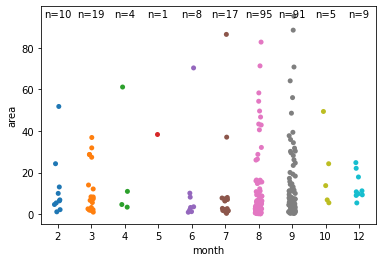

In [13]:
plot = sns.stripplot(x = 'month', y = 'area', data = fires_df[fires_df.area < 100][fires_df.area > 0])
nobs = fires_df[fires_df.area < 100][fires_df.area > 0].groupby('month')['area'].count()
for i,n in enumerate(nobs):
    plot.annotate(f'n={n}', xy=(i, 0.95), xycoords=('data','axes fraction'), ha='center')

Z wykresu widać, że najwięcej pożarów miało miejsce w sierpniu. Niewiele mniej pozarów, bo 91, zostało zarejestrowanych we wrześniu, były one jednak z reguły bardziej dotkliwe. Co ciekawe, z wykresu możemy również wyczytać, że w styczniu i listopadzie nie zarejestrowano ani jednego pożaru a w maju tylko jeden. Nie wynika to jednak z ekstremalnie niskiej skłonności do pożarów w tych miesiącach, a raczej z niekompletności danych.

Podobny wykres możemy sporządzić dla dni tygodnia.

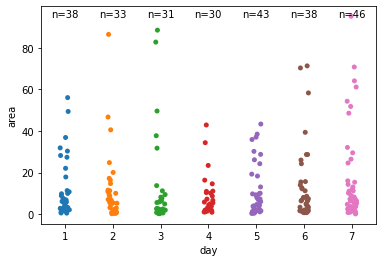

In [14]:
plot = sns.stripplot(x = 'day', y = 'area', data = fires_df[fires_df.area < 100][fires_df.area > 0])
nobs = fires_df[fires_df.area < 100][fires_df.area > 0].groupby('day')['area'].count()
for i,n in enumerate(nobs):
    plot.annotate(f'n={n}', xy=(i, 0.95), xycoords=('data','axes fraction'), ha='center')

Na koniec sprawdźmy czy są jakieś rejony, w których ryzyko pożaru jest istotnie wyższe.

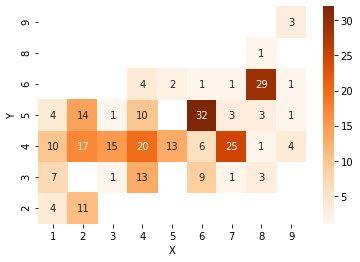

In [15]:
fires_heatmap = fires_df[fires_df.area > 0][['X', 'Y', 'area']].groupby(['X', 'Y']).count().reset_index()
sns.heatmap(fires_heatmap.pivot('Y', 'X', 'area'), cmap="Oranges", annot = True).invert_yaxis()

Widzimy że najwięcej pożarów miało miejsce w lokalizacji o kordynatach (6, 5).

Do eksploracji danych możemy użyć również narzędzia pandas_profiling:

In [16]:
report = ProfileReport(fires_df);
report.to_file(output_file='report.html');

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Wynik tej automatycznej analizy można zobaczyć tu: [link](report.html)

Nie da się ukryć, że narzędzie pandas_profiling jest bardzo wygodne. Wystarczy jedna linijka kodu, żeby wygenerować dosyć obszerny i interaktywny raport o naszej ramce danych. Problemem wydaje się być długi czas generowania raportu. W tym wypadku, dla 517 rekordów raport generował się ok. 30 sekund. Dla dużo większej ilości danych może się okazać, że narzędzie to będzie nieużywalne. Oprócz tego, eksplorując dane na własną ręke jesteśmy dużo bardziej elastyczni, możemy pokazać niestandardowe zależności, których raport nie obejmuje oraz mamy więcej narzędzi do wizualizacji w naszym arsenale. Mimo to pandas_profiling wygląda na świetnego zastępce pierwszych kroków eksploracji danych (np. head(), info(), shape()).